* Goals for today
    * I assume familiarity with QICK (that's why we're here)
        * I'm happy to talk about topics from the tutorial demos (ASM programming, sweeps, feedback, timing, etc.) if there's demand
    * But let's spend some time to understand what goes on under the hood, so you can better understand what QICK does
    * Then, we can choose between misc. topics:
        * direct digtal synthesis in higher Nyquist zones
        * phase measurement in single-tone spectroscopy
        * advanced phase control
        * external RF reference
        * anything else you want to talk about

* Resources
    * software, firmware, demos, source, bug reports: https://github.com/openquantumhardware/qick/
        * you should subscribe to notifications
    * documentation: https://qick-docs.readthedocs.io/
    * talk to us: #qick on http://discord.unitary.fund/
        * we can answer questions and make custom firmware images

* caveats
    * I'm using the ZCU216 for this demo, but this is all applicable to the 111 and 4x2 (different sampling frequencies, bandwidths)
    * I'm not covering the other generators/readouts that are not part of the standard firmware
    * this (like the pulsed QICK firmware in general) is fairly specific to superconducting qubits
        * we could talk a bit about the other firmwares (MKID readout, spectrum analyzer) and AMO needs


In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from matplotlib import colors
from tqdm.notebook import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


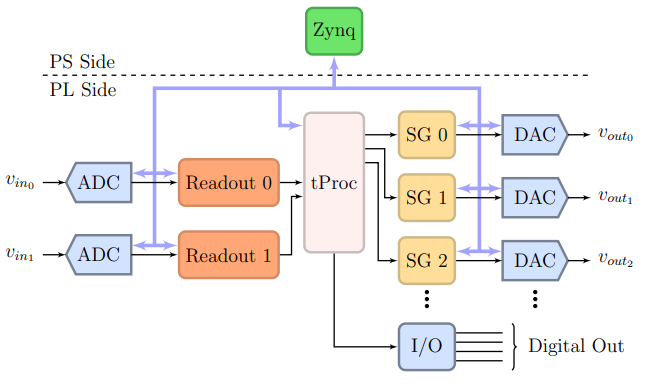

In [63]:
soc = QickSoc()
soccfg = soc
print(soccfg)


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	1:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	2:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	3:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	4:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 6, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_signal_gen_v6 - tProc out

In [64]:
def plot_decimated(iq_list, soccfg, config, plot_iq=True):
    fig, axs = plt.subplots(2,1,figsize=(10,10))
    t = soccfg.cycles2us(np.arange(len(iq_list[0][0])), ro_ch=config['ro_chs'][0])

    for ii, iq in enumerate(iq_list):
        plot = axs[ii]
        if plot_iq:
            plot.plot(t, iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
            plot.plot(t, iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
            plot.plot(t, np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
        else:
            plot.plot(t, iq[0], label="input value, ADC %d"%(config['ro_chs'][ii]))
        plot.set_ylabel("a.u.")
        plot.set_xlabel("Time [us]")
        plot.set_title("Averages = " + str(config["soft_avgs"]))
        plot.legend()
        
def plot_accumulated(iq_list, d_buf, prog, config, span=100):
    fig, axs = plt.subplots(2,1,figsize=(10,10))
    iqs = np.array(iq_list)[:,:,0].T

    for ii, (iq, buf, ch) in enumerate(zip(iqs, d_buf, prog.ro_chs)):
        plot = axs[ii]
        nsamp = prog.ro_chs[ch]['length']
        center = iq*nsamp
        hrange = [[center[0]-span, center[0]+span],[center[1]-span, center[1]+span]]
        plot.hist2d(buf[:,0], buf[:,1], bins=100, range=hrange, norm=colors.LogNorm())
        plot.set_xlabel("I value, ADC %d"%(config['ro_chs'][ii]))
        plot.set_ylabel("Q value, ADC %d"%(config['ro_chs'][ii]))
        
def noise(prog):
    diq = (prog.di_buf+1j*prog.dq_buf)/next(iter(prog.ro_chs.values()))['length']
    dmean = np.mean(diq,axis=1)
    dmag = np.abs(dmean)
    drotated = diq*np.exp(-1j*np.angle(dmean))[:,np.newaxis]
    drmsmag = np.std(np.real(drotated),axis=1) # noise in the radial direction
    drmsrot = np.std(np.imag(drotated), axis=1) # noise in the azimuth direction
    return drmsmag, drmsrot

### an example program

In [65]:
class FSGenLoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg = self.cfg
        style = cfg['style']
        for iCh, ch in enumerate(cfg["gen_chs"]):  # configure the pulse lengths and upconversion frequencies
            length_gen = self.us2cycles(cfg['length'], gen_ch=ch)
            self.declare_gen(ch=ch, nqz=cfg['nqz'][iCh], ro_ch=cfg["ro_chs"][0])
            
            self.default_pulse_registers(ch=ch, 
                         freq=self.freq2reg(cfg['pulse_freq'],gen_ch=ch,ro_ch=cfg["ro_chs"][0]),
                         gain=cfg['pulse_gain'],
                         mode=cfg['mode'],
                         phase=0)

            if style == "const":
                self.set_pulse_registers(ch=ch, style=style, length=length_gen)
            elif style == "arb":
                self.add_gauss(ch=ch, name="measure", sigma=length_gen/5, length=length_gen)
                self.set_pulse_registers(ch=ch, style=style, waveform="measure")

        for iCh, ch in enumerate(cfg["ro_chs"]):  # configure the readout lengths and downconversion frequencies
            length_ro = self.us2cycles(cfg['length']+cfg['readout_padding'], ro_ch=ch)
            
            self.declare_readout(ch=ch, freq=cfg["pulse_freq"],
                                 length=length_ro,
                                 sel=cfg['ro_sel'],
                                 gen_ch=cfg["gen_chs"][0])

        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.measure(pulse_ch=self.cfg["gen_chs"],
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]),
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

config = {
    'gen_chs': [4,6],
    'ro_chs': [0,1],
    'nqz': [1,1],
    'ro_sel': 'product',
    'style': 'arb',
    'mode': 'oneshot',
    'pulse_gain': 30000,    # a.u.
    'pulse_freq': 80,       # MHz
    'adc_trig_offset': 0.4, # us
    'length': 0.3,          # us
    'readout_padding': 0.1, # us
    'relax_delay': 2,       # us
    'reps': 1,
    'soft_avgs': 1
}
prog = FSGenLoopbackProgram(soccfg, config)
print(prog)


// Program

        regwi 3, $11, 49932190;                 //freq = 49932190
        regwi 3, $12, 0;                        //phase = 0
        regwi 3, $14, 30000;                    //gain = 30000
        regwi 3, $13, 0;                        //addr = 0
        regwi 3, $15, 524417;                   //phrst| stdysel | mode | | outsel = 0b01000 | length = 129 
        regwi 4, $11, 49932190;                 //freq = 49932190
        regwi 4, $12, 0;                        //phase = 0
        regwi 4, $14, 30000;                    //gain = 30000
        regwi 4, $13, 0;                        //addr = 0
        regwi 4, $15, 524417;                   //phrst| stdysel | mode | | outsel = 0b01000 | length = 129 
        synci 200;
        regwi 0, $15, 0;
        regwi 0, $14, 0;
LOOP_J: regwi 0, $31, 49153;                    //out = 0b1100000000000001
        seti 0, 0, $31, 172;                    //ch =0 out = $31 @t = 0
        seti 0, 0, $0, 182;                     //ch =0 

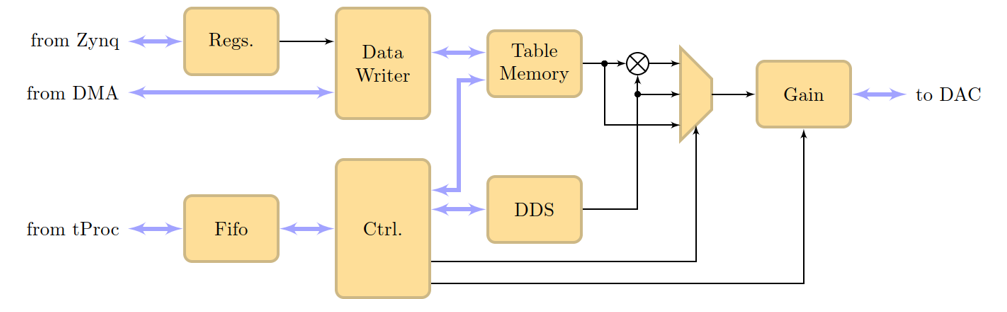

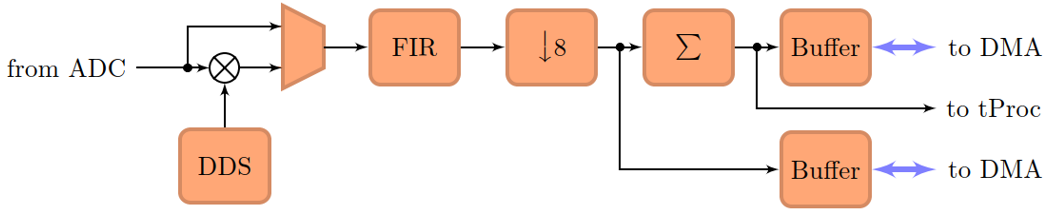

### let's look at low-frequency pulses with direct readout and on the scope

  0%|          | 0/100 [00:00<?, ?it/s]

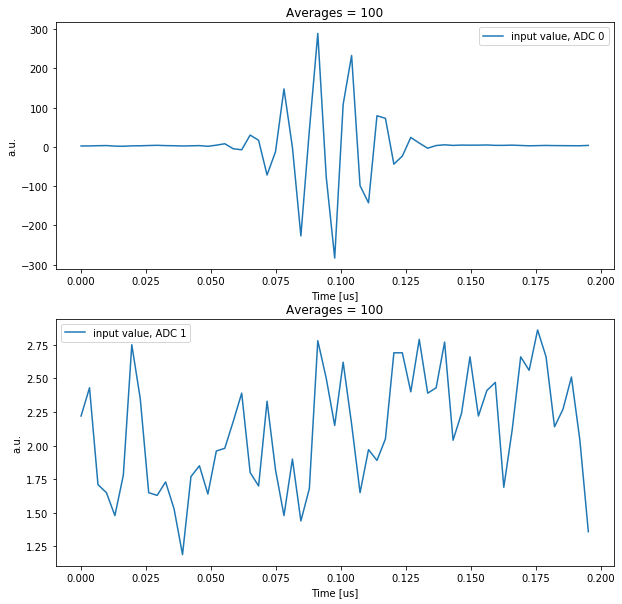

In [70]:
config = {
    'gen_chs': [4,6],
    'ro_chs': [0,1],
    'nqz': [1,1],
    'ro_sel': 'input',
#     'style': 'const',
    'style': 'arb',
    'mode': 'oneshot',
    'pulse_gain': 30000,
    'pulse_freq': 80,
    'adc_trig_offset': 0.4,
    'length': 0.1,
    'readout_padding': 0.1,
    'relax_delay': 2,
    'reps': 1,
    'soft_avgs': 1
#     'soft_avgs': 100
}
prog = FSGenLoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)
# Plot results.
plot_decimated(iq_list, soccfg, config, plot_iq=False)

### let's look at pulses with downconverted readout, and go to higher frequency
phase coherence!

  0%|          | 0/1000 [00:00<?, ?it/s]

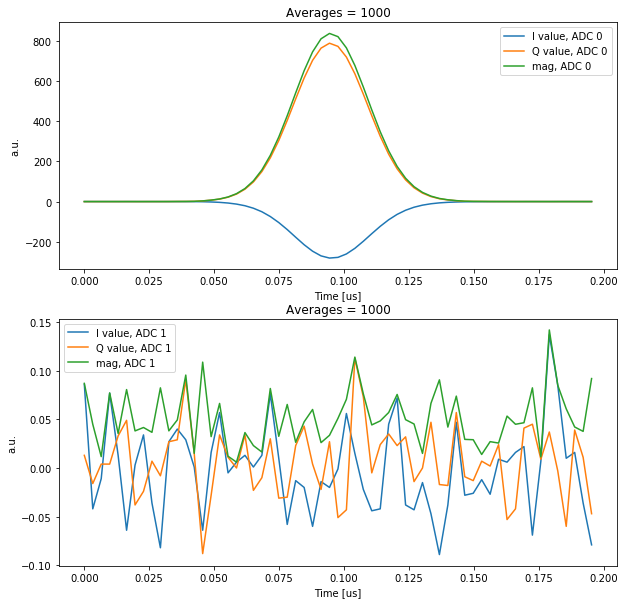

In [71]:
config = {
    'gen_chs': [4,6],
    'ro_chs': [0,1],
    'ro_sel': 'product',
    'nqz': [1,1],
#     'style': 'const',
    'style': 'arb',
    'mode': 'oneshot',
    'pulse_gain': 32000,
#     'pulse_freq': 80,
    'pulse_freq': 800,
    'adc_trig_offset': 0.4,
    'length': 0.1,
    'readout_padding': 0.1,
    'relax_delay': 2,
    'reps': 1,
#     'soft_avgs': 1
    'soft_avgs': 1000
}
prog = FSGenLoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)
# Plot results.
plot_decimated(iq_list, soccfg, config, plot_iq=True)

### let's switch to accumulated readout
much faster!

  0%|          | 0/100000 [00:00<?, ?it/s]

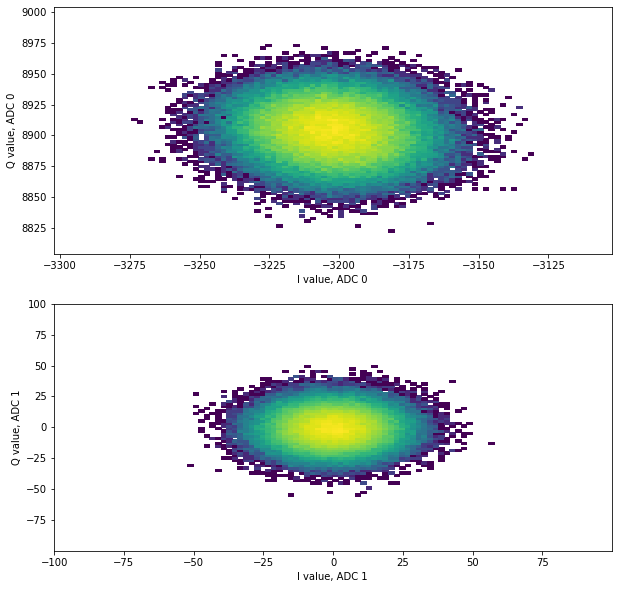

In [72]:
config = {
    'gen_chs': [4,6],
    'ro_chs': [0,1],
    'nqz': [1,1],
    'ro_sel': 'product',
#     'style': 'const',
    'style': 'arb',
    'mode': 'oneshot',
    'pulse_gain': 32000,
#     'pulse_freq': 80,
    'pulse_freq': 800,
    'adc_trig_offset': 0.4,
    'length': 0.1,
    'readout_padding': 0.1,
    'relax_delay': 2,
#     'reps': 1,
    'reps': 100000,
    'soft_avgs': 1
}
prog = FSGenLoopbackProgram(soccfg, config)
prog.acquire(soc, progress=False)
iq_list = prog.acquire(soc, progress=True)
d_buf = np.stack([prog.di_buf, prog.dq_buf], axis=-1)
# Plot results.
plot_accumulated(iq_list, d_buf, prog, config, span=100)

### go to high frequency (with appropriate baluns), do a frequency sweep

  0%|          | 0/101 [00:00<?, ?it/s]

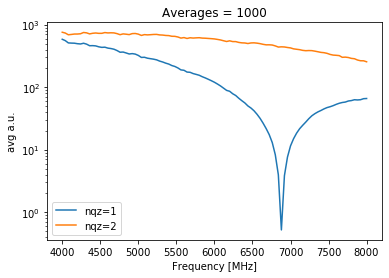

In [73]:
config = {
    'gen_chs': [0],
    'ro_chs': [1],
    'nqz': [2],
    'ro_sel': 'product',
    'style': 'const',
    'mode': 'oneshot',
    'pulse_gain': 32000,
    'adc_trig_offset': 0.4,
    'length': 5,
    'readout_padding': 0.1,
    'relax_delay': 1,
    'reps': 1000,
    'soft_avgs': 1
}

freqs = np.linspace(start=4000, stop=8000, num=101)
means = np.zeros((len(freqs),2), dtype=complex)

for i, f in tqdm(list(enumerate(freqs))):
    for j, nqz in enumerate([1,2]):
        config['pulse_freq'] = f
        config['nqz'] = [nqz]

        prog = FSGenLoopbackProgram(soccfg, config)
        res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
        means[i,j] = np.array(res).T[0].dot([1,1j])

fig, axs = plt.subplots()
plot = axs
plot.semilogy(freqs, np.abs(means[:,0]), label="nqz=1")
plot.semilogy(freqs, np.abs(means[:,1]), label="nqz=2")
plot.set_ylabel("avg a.u.")
plot.set_xlabel("Frequency [MHz]")
plot.set_title("Averages = " + str(config["reps"]))
plot.legend()

Xilinx doc on DAC modes (nqz=1 is "normal" and should be used in 1st Nyquist zone, nqz=2 is "mix-mode" and should be used in 2nd and above): https://docs.xilinx.com/r/en-US/pg269-rf-data-converter/RF-DAC-Nyquist-Zone-Operation

This plot shows performance for an ideal infinite-bandwidth DAC. The gain fluctuation is just coming from the "zero-order hold" behavior of the DAC.

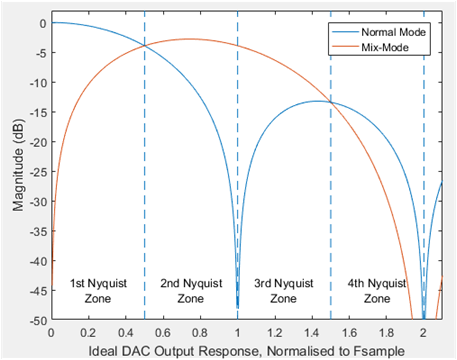

Note that the ADC is happily operating in 5th or 6th Nyquist zone.

### add a cavity

  0%|          | 0/101 [00:00<?, ?it/s]

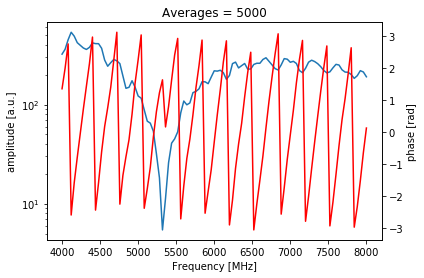

In [74]:
config = {
    'gen_chs': [0],
    'ro_chs': [1],
    'nqz': [2],
    'ro_sel': 'product',
    'style': 'const',
    'mode': 'oneshot',
    'pulse_gain': 32000,
    'adc_trig_offset': 0.4,
    'length': 5,
    'readout_padding': 0.1,
    'relax_delay': 1,
    'reps': 5000,
    'soft_avgs': 1
}

freqs = soccfg.adcfreq(np.linspace(start=4000, stop=8000, num=101),
                       gen_ch=config['gen_chs'][0],
                       ro_ch=config['ro_chs'][0])
means = np.zeros((len(freqs),1), dtype=complex)

for i, f in tqdm(list(enumerate(freqs))):
    config['pulse_freq'] = f
    
    prog = FSGenLoopbackProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    means[i] = np.array(res).T[0].dot([1,1j])

fig, plot = plt.subplots()
plot.semilogy(freqs, np.abs(means[:,0]), label="amplitude")
ax2 = plot.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(freqs, np.angle(means[:,0]),color='red', label='phase')
plot.set_ylabel("amplitude [a.u.]")
ax2.set_ylabel("phase [rad]")

plot.set_xlabel("Frequency [MHz]")
plot.set_title("Averages = " + str(config["reps"]))

cavity_data = (freqs, means)

### calibrate the phase delay
What we're doing here is the same thing as in the "01_Phase_coherent_readout" demo (but simplified, and iterated to cover this large frequency range).

In [75]:
config = {
    'gen_chs': [0],
    'ro_chs': [1],
    'nqz': [2],
    'ro_sel': 'product',
    'style': 'const',
    'mode': 'oneshot',
    'pulse_gain': 32000,
    'adc_trig_offset': 0.4,
    'length': 5,
    'readout_padding': 0.1,
    'relax_delay': 1,
    'reps': 1000,
    'soft_avgs': 1
}

freqs = soccfg.adcfreq(np.linspace(start=4000, stop=4000.1, num=101))
means = np.zeros((len(freqs),1), dtype=complex)

for i, f in tqdm(list(enumerate(freqs))):
    config['pulse_freq'] = f
    
    prog = FSGenLoopbackProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    means[i] = np.array(res).T[0].dot([1,1j])

a = np.vstack([freqs, np.ones_like(freqs)]).T
phase_correction = np.linalg.lstsq(a, np.unwrap(np.angle(means[:,0])), rcond=None)[0][0]/(2*np.pi)
print("first pass: delay %.4f us"%(phase_correction))

freqs = soccfg.adcfreq(np.linspace(start=4000, stop=4100, num=101))
means = np.zeros((len(freqs),1), dtype=complex)

for i, f in tqdm(list(enumerate(freqs))):
    config['pulse_freq'] = f
    
    prog = FSGenLoopbackProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    means[i] = np.array(res).T[0].dot([1,1j])

means_rotated = means*np.exp(-1j*freqs[:,np.newaxis]*2*np.pi*phase_correction)

a = np.vstack([freqs, np.ones_like(freqs)]).T
phase_trim = np.linalg.lstsq(a, np.unwrap(np.angle(means_rotated[:,0])), rcond=None)[0][0]/(2*np.pi)
phase_correction += phase_trim
print("second pass: trim %.4f us, total delay %.4f us"%(phase_trim, phase_correction))

  0%|          | 0/101 [00:00<?, ?it/s]

first pass: delay -3.4379 us


  0%|          | 0/101 [00:00<?, ?it/s]

second pass: trim -0.0594 us, total delay -3.4973 us


### apply the phase correction

Text(0, 0.5, 'phase [rad]')

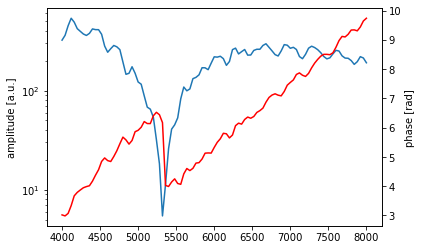

In [76]:
freqs, means = cavity_data
means_rotated = means*np.exp(-1j*freqs[:,np.newaxis]*2*np.pi*phase_correction)

fig, plot = plt.subplots()
plot.semilogy(freqs, np.abs(means_rotated[:,0]), label="amplitude")
ax2 = plot.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(freqs, np.unwrap(np.angle(means_rotated[:,0])),color='red', label='phase')
plot.set_ylabel("amplitude [a.u.]")
ax2.set_ylabel("phase [rad]")
# plot.set_title("Averages = " + str(config["reps"]))

### phase reset
Normally the generator and readout oscillators are phase-coherent (they maintain the same phase, between shots and runs; if you change frequency and come back to the original frequency, you come back to the same phase). 
* This is what you want for reading out resonators (you want the DAC and ADC to maintain constant relative phase)
* This is also what you want for a qubit drive (when you play a sequence of gates at the resonant frequency, each gate should have the correct phase relative to the qubit's internal phase)

But you might need to play two gates that have different frequencies, but need a fixed relationship both in time and in phase. (Michael Hatridge's talk) This is impossible in the above picture - if you imagine two free-running oscillators at different frequencies, their phase angle will rotate at the difference frequency.

The solution is to reset the generator oscillator phases at the start of each shot.

If you need to do a phase reset on a readout tone, you will also need to do a phase reset on the readout oscillator. This requires a special firmware and changes to your program.

In [108]:
class PhrstProgram(AveragerProgram):
    def initialize(self):
        cfg = self.cfg
        style = cfg['style']
        for iCh, ch in enumerate(cfg["gen_chs"]):  # configure the pulse lengths and upconversion frequencies
            length_gen = self.us2cycles(cfg['length'], gen_ch=ch)
            self.declare_gen(ch=ch, nqz=cfg['nqz'][iCh], ro_ch=cfg["ro_chs"][0])
            delta_freq = cfg['delta_freq'] if iCh==1 else 0
            
            self.default_pulse_registers(ch=ch, 
#                          gen_ch=ch,ro_ch=cfg["ro_chs"][0],
                         gain=cfg['pulse_gain'],
                         phase=0,
                         phrst=cfg['phrst'])

            if style == "const":
                self.set_pulse_registers(ch=ch, style=style, length=length_gen,
                                         freq=self.freq2reg(cfg['pulse_freq']+delta_freq))
            elif style == "arb":
                iqdata = 32000*np.exp(2j*pi*self.cycles2us(np.arange(length_gen*16), gen_ch=ch)/16*delta_freq)
                idata = np.real(iqdata).astype(np.int16)
                qdata = np.imag(iqdata).astype(np.int16)
                self.add_pulse(ch=ch, name="measure", idata=idata, qdata=qdata)
#                 self.add_gauss(ch=ch, name="measure", sigma=length_gen/5, length=length_gen)
                self.set_pulse_registers(ch=ch, style=style, waveform="measure",
                                         freq=self.freq2reg(cfg['pulse_freq']))

        for iCh, ch in enumerate(cfg["ro_chs"]):  # configure the readout lengths and downconversion frequencies
            length_ro = self.us2cycles(cfg['length']+cfg['readout_padding'], ro_ch=ch)
            
            self.declare_readout(ch=ch, freq=cfg["pulse_freq"],
                                 length=length_ro,
                                 sel=cfg['ro_sel'],
                                 gen_ch=cfg["gen_chs"][0])

        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.measure(pulse_ch=self.cfg["gen_chs"],
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]),
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

config = {
    'gen_chs': [6,4],
    'ro_chs': [0,1],
    'nqz': [1,1],
    'ro_sel': 'product',
#     'style': 'const',
    'style': 'arb',
    'phrst': 0,
#     'phrst': 1,
    'pulse_gain': 30000,    # a.u.
    'pulse_freq': 40,       # MHz
    'delta_freq': 1,
    'adc_trig_offset': 0.4, # us
    'length': 0.2,          # us
    'readout_padding': 0.1, # us
    'relax_delay': 2,       # us
    'reps': 1,
    'soft_avgs': 1
#     'soft_avgs': 100
}
prog = PhrstProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)
# Plot results.
# plot_decimated(iq_list, soccfg, config, plot_iq=True)

  0%|          | 0/1 [00:00<?, ?it/s]

### external reference
If you want better stability than you get from the internal reference oscillator (which is not very good), you can lock to an external reference.

In [111]:
config = {
    'gen_chs': [0],
    'ro_chs': [1],
    'nqz': [2],
    'pulse_freq': 6000,
    'ro_sel': 'product',
    'style': 'const',
    'mode': 'periodic',
    'pulse_gain': 32000,
    'adc_trig_offset': 0.4,
    'length': 5,
    'readout_padding': 0.1,
    'relax_delay': 1,
    'reps': 1,
    'soft_avgs': 1
}

excited=FSGenLoopbackProgram(soccfg, config)
# ground=NoPulse(soccfg, config)
avgEi, avgEq = excited.acquire(soc, load_pulses=True,progress=True, debug=False)

  0%|          | 0/1 [00:00<?, ?it/s]

In [110]:
# soc = QickSoc(external_clk=False)
soc = QickSoc(external_clk=True)
soccfg = soc

resetting clocks: 245.76 491.52


In [ ]:
# reset periodic pulses
soc.reset_gens()